# run entire `provabgs` pipeline on fake observations generated using the pipeline
This will serve as an internal test that the model and inference pipelines are working!

In [1]:
import os
import numpy as np 
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#if 'NERSC_HOST' not in os.environ.keys():
#    mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
import gqp_mc.util as UT

In [3]:
from provabgs import infer as Infer
from provabgs import models as Models
from provabgs import corrprior as Corrprior

/global/u1/c/chahah/projects/provabgs/src/provabgs/models.py:25: UserWarning: import error with fsps; only use emulators
  warnings.warn('import error with fsps; only use emulators')


In [4]:
prior = Infer.load_priors([
    Infer.UniformPrior(9., 12., label='sed'), 
    Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
    Infer.UniformPrior(0., 1., label='sed'), # burst fraction
    Infer.UniformPrior(0., 13.27, label='sed'), # tburst
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1 
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
    Infer.UniformPrior(-2.2, 0.4, label='sed')     # uniform priors on dust_index 
])

# generate fake observations

In [5]:
wave_obs = np.load('/global/cscratch1/sd/chahah/gqp_mc/mini_mocha/provabgs_mocks/provabgs_mock.wave.npy')
theta_obs = np.load('/global/cscratch1/sd/chahah/gqp_mc/mini_mocha/provabgs_mocks/provabgs_mock.theta.npy')
flux_obs = np.load('/global/cscratch1/sd/chahah/gqp_mc/mini_mocha/provabgs_mocks/provabgs_mock.flux.npy')
z_obs = 0.2

In [7]:
unt_theta_obs = prior.untransform(theta_obs)

In [8]:
m_nmf = Models.NMF(burst=True, emulator=True)

(3000.0, 10000.0)

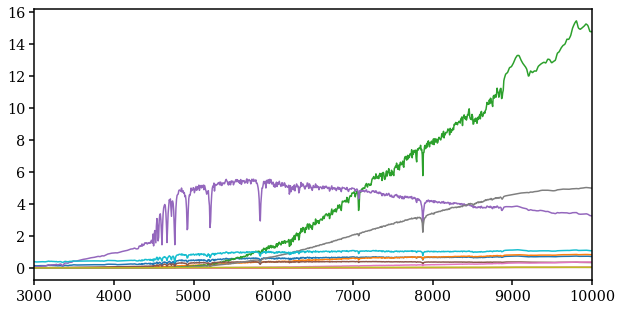

In [9]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for f in flux_obs[:10]: sub.plot(wave_obs, f)
sub.set_xlim(3e3, 1e4)

# load in MCMC chains run on cori

In [10]:
desi_mcmc = Infer.desiMCMC(model=m_nmf, prior=prior)

In [11]:
chain_dir = os.path.join(UT.dat_dir(), 'mini_mocha', 'provabgs_mocks')
f_chain = lambda i: os.path.join(chain_dir, 'provabgs_mock.%i.chain.npy' % i)

In [12]:
chains = [] 
for i in range(theta_obs.shape[0]): 
    chains.append(np.load(f_chain(i)))

/global/u1/c/chahah/projects/provabgs/src/provabgs/models.py:908: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
/global/u1/c/chahah/projects/provabgs/src/provabgs/models.py:908: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
/global/u1/c/chahah/projects/provabgs/src/provabgs/models.py:849: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])


[1.01390127e+01 3.91571329e-01 9.02925829e-01 5.26697840e-01
 3.40199486e-01 6.88412113e+00 3.29431210e-03 1.93145680e-03
 8.05072701e-01 1.18940177e+00 2.30787999e-01]
-4.73326172782329e-30
[1.01378496e+01 7.24031008e-01 5.37612579e-01 3.91767077e-01
 4.45647502e-01 1.06623879e+01 6.26107467e-03 2.75051631e-03
 1.02070228e+00 1.01506152e+00 6.11461948e-02]
-0.0899189587312203
[ 1.01411885e+01  1.91344665e-01  1.74655028e-01  9.15617735e-01
  8.00960900e-01  7.92339993e+00  4.32473759e-03  8.30121109e-04
  2.09031622e+00  1.03557692e+00 -1.20725626e+00]
0.0
[ 1.06321323e+01  6.86710192e-01  7.06032561e-01  9.92687173e-01
  6.71131408e-01  1.24670975e+01  2.29779174e-03  5.10890979e-03
  1.18666327e+00  8.84814892e-01 -1.48200768e+00]
-0.03261390995812682


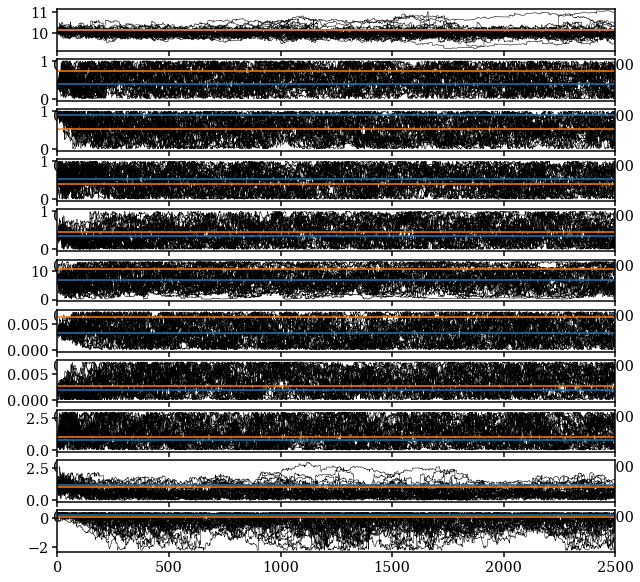

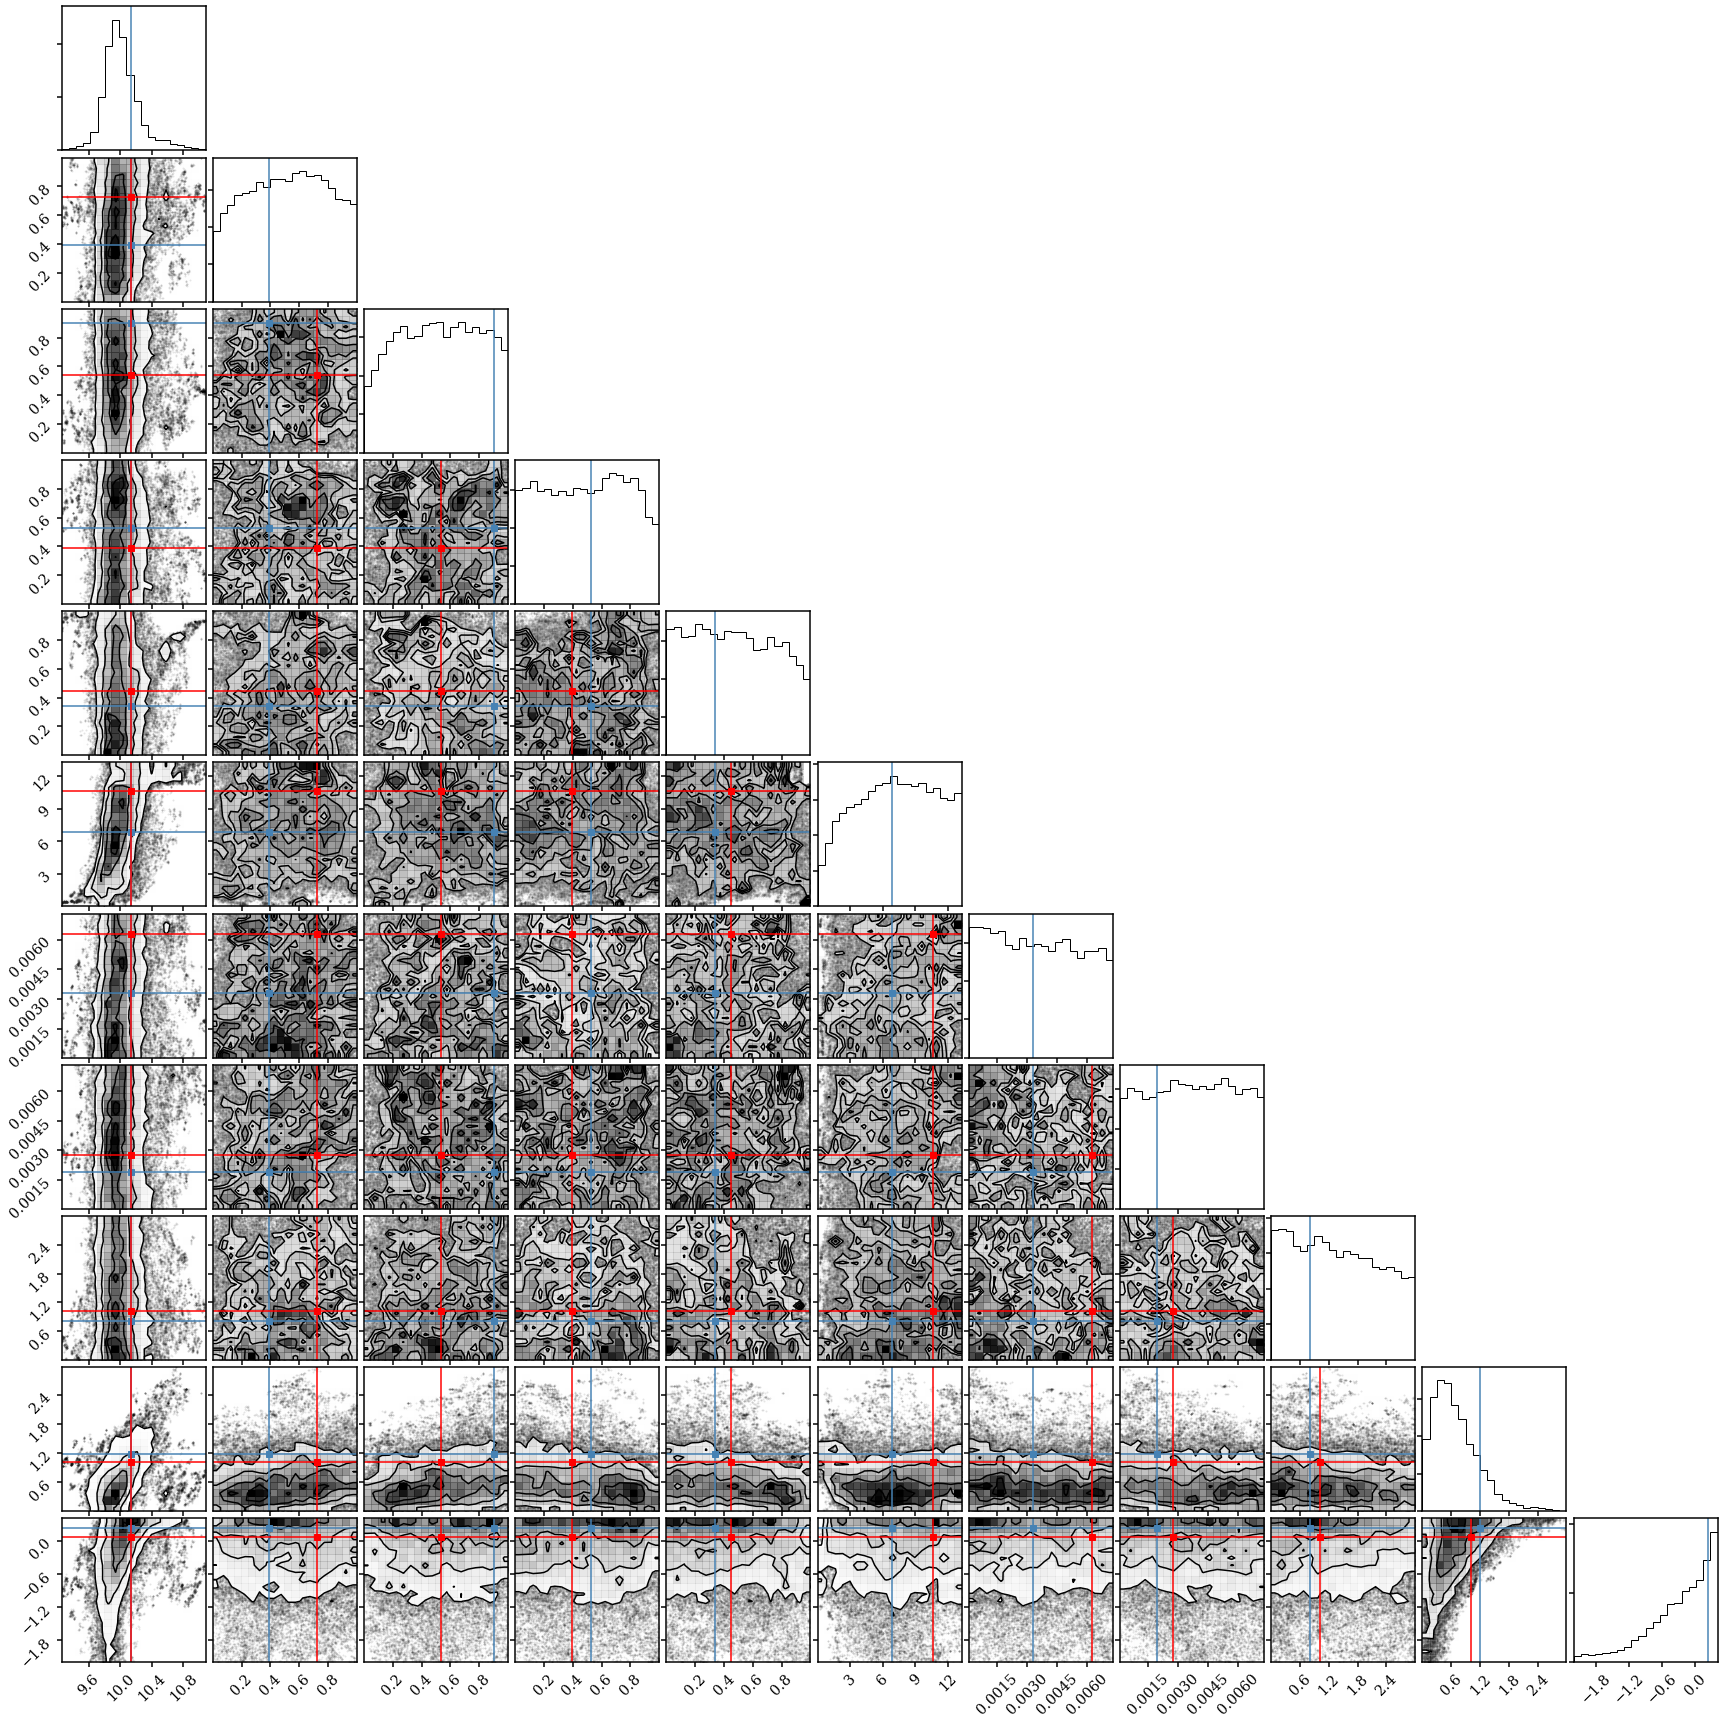

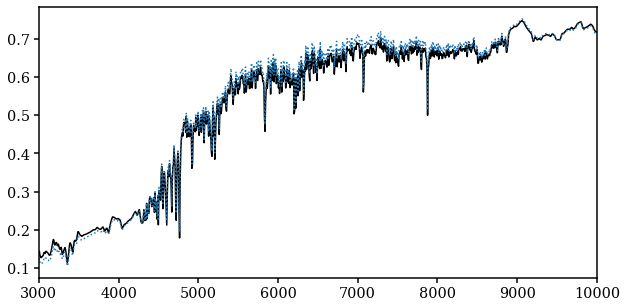

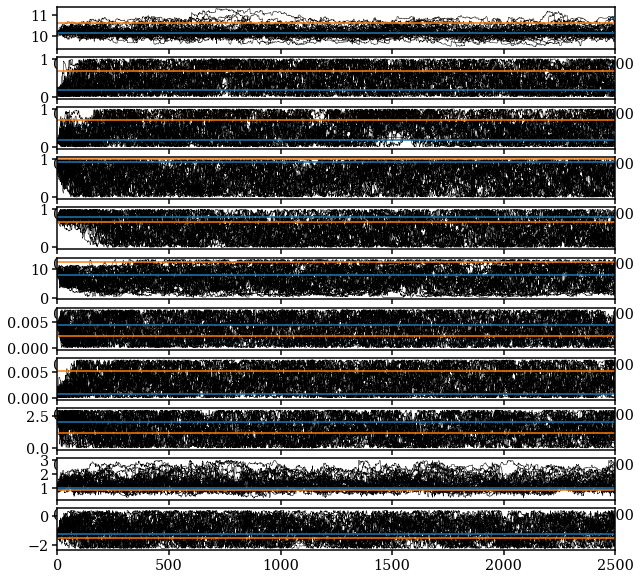

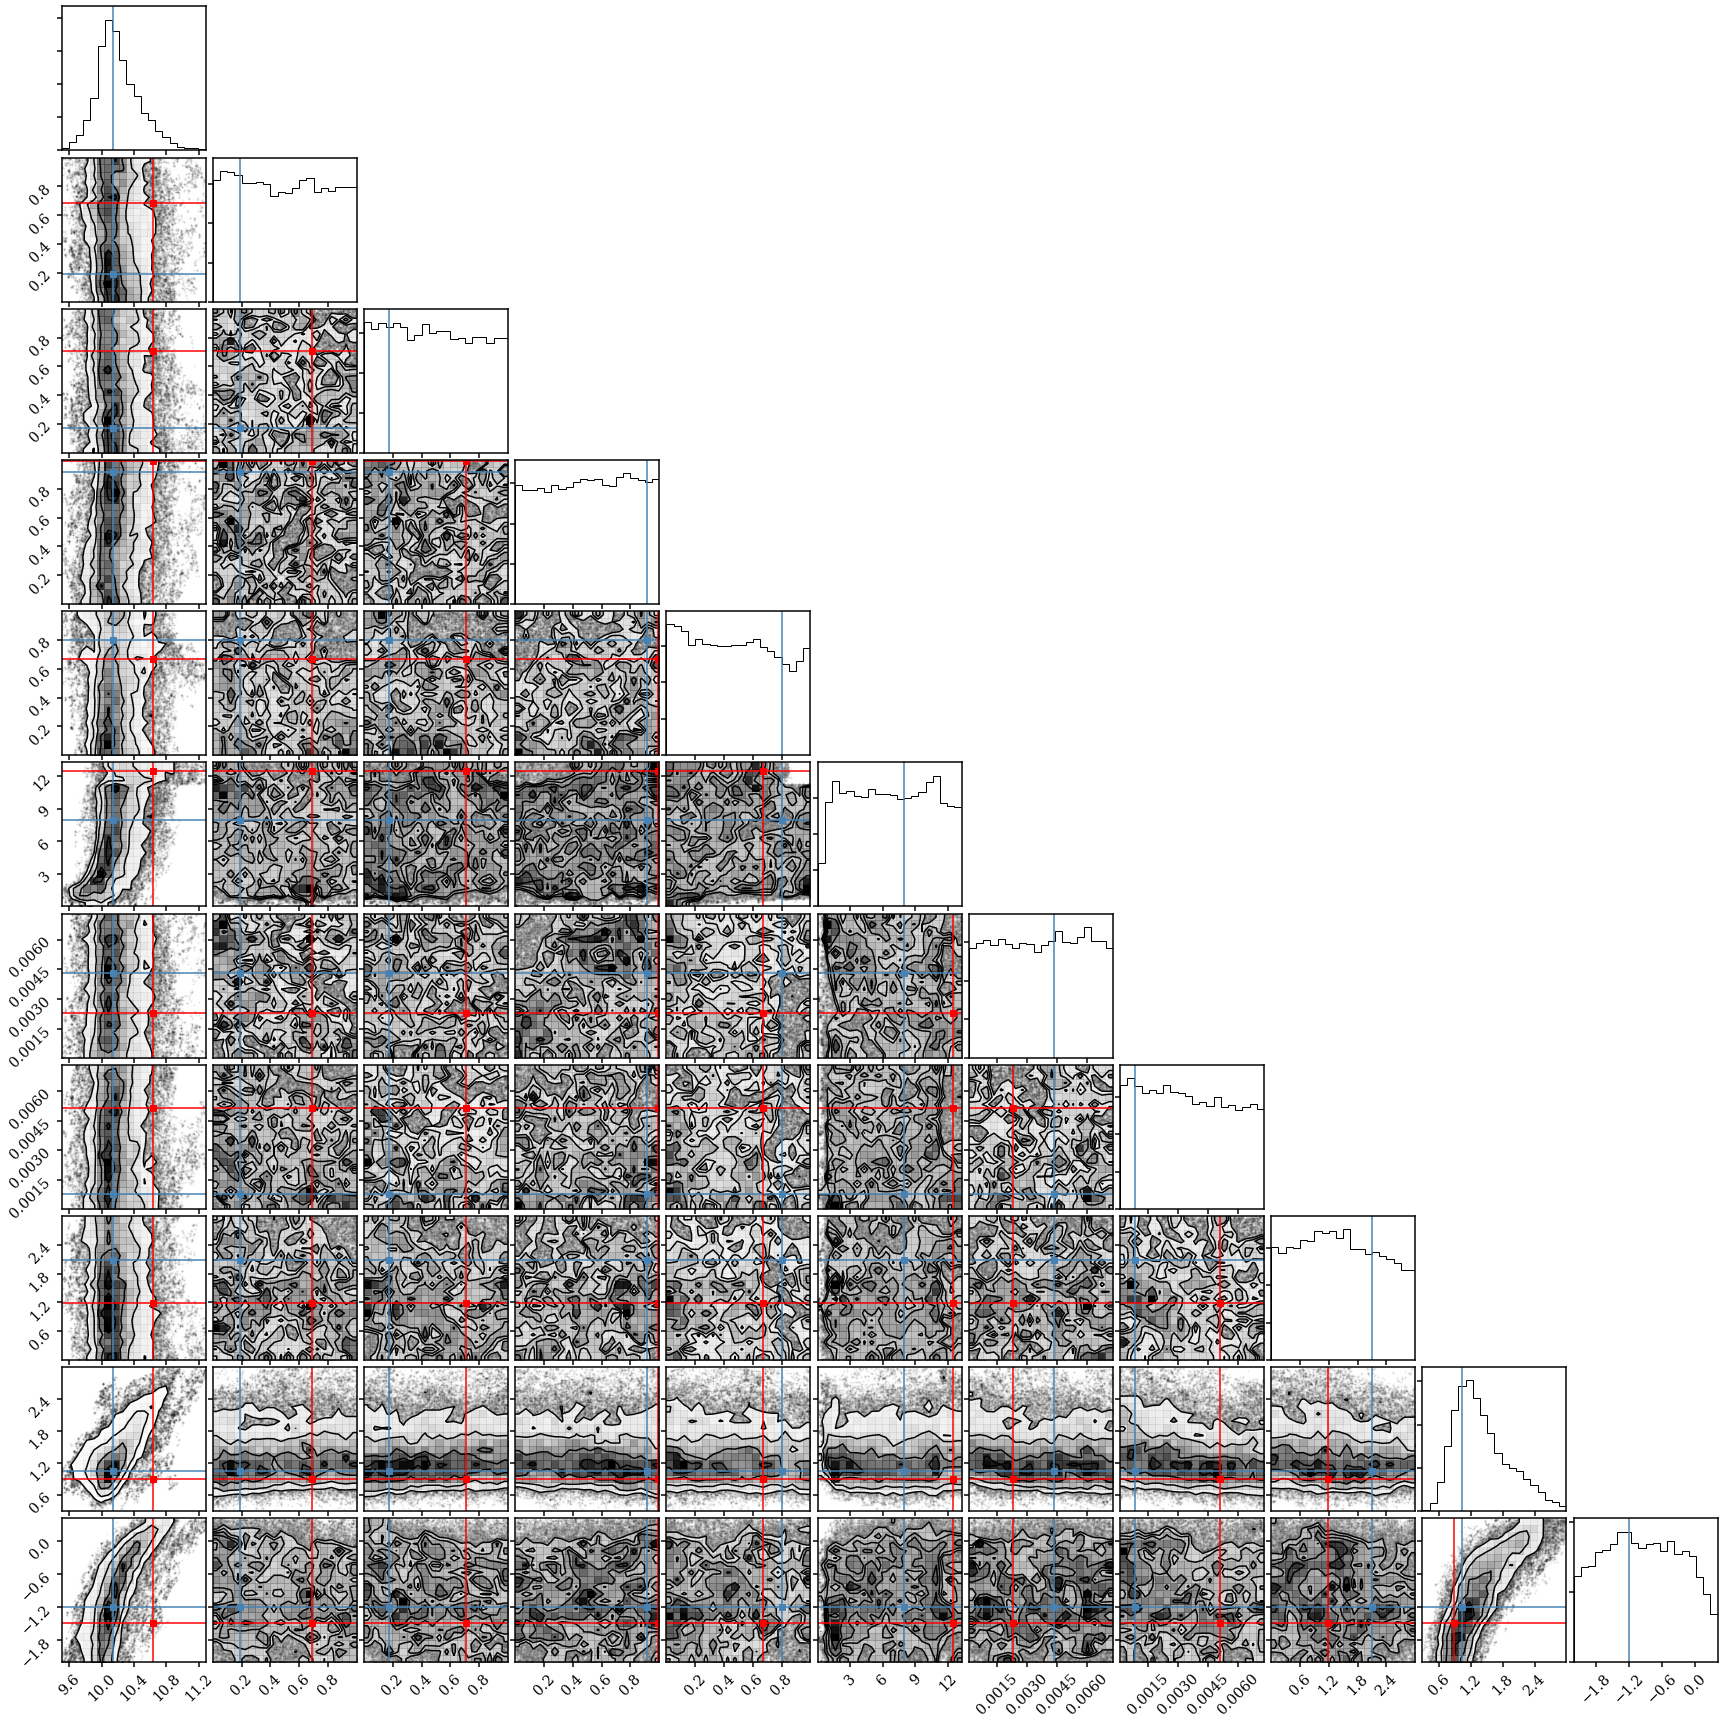

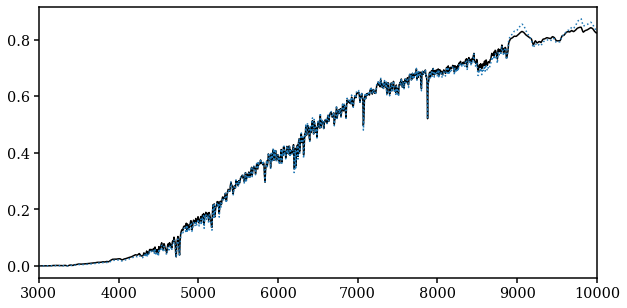

In [13]:
for i, chain in enumerate(chains[:2]): 
    flat_chain = desi_mcmc._flatten_chain(chain[500:,:,:])    
    unt_chain = prior.untransform(flat_chain)
    
    args, kwargs = desi_mcmc._lnPost_args_kwargs(
        wave_obs=wave_obs, 
        flux_obs=flux_obs[i], 
        flux_ivar_obs=np.ones(len(wave_obs)), 
        zred=z_obs, 
        vdisp=0
    )
    tts, lnPs = [], []
    for tt in unt_chain[::100]: 
        tts.append(tt)
        lnPs.append(desi_mcmc.lnPost(tt, *args, **kwargs))
    unt_theta_bf = tts[np.argmax(lnPs)]
    unt_theta_median = np.median(unt_chain, axis=0)
    
    print(unt_theta_obs[i])
    print(desi_mcmc.lnPost(unt_theta_obs[i], *args, **kwargs))
    print(unt_theta_bf)
    print(np.max(lnPs))

    unt_theta_bf = tts[np.argmax(lnPs)]
    
    fig = plt.figure(figsize=(10, 10))
    for ii in range(theta_obs.shape[1]-1): 
        sub = fig.add_subplot(theta_obs.shape[1]-1, 1, ii+1)
        for j in range(30): 
            unt_chain_i = desi_mcmc.prior.untransform(chain[:,j,:])
            sub.plot(unt_chain_i[:,ii], c='k', lw=0.5)
        sub.axhline(unt_theta_obs[i][ii], color='C0')
        sub.axhline(unt_theta_bf[ii], color='C1')
        sub.set_xlim(0,2500)
    
    fig = DFM.corner(unt_chain, truths=unt_theta_obs[i])
    
    axes = np.array(fig.axes).reshape((unt_theta_obs.shape[1], unt_theta_obs.shape[1]))

    # Loop over the histograms
    for yi in range(unt_theta_obs.shape[1]):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(unt_theta_bf[xi], color="r")
            ax.axhline(unt_theta_bf[yi], color="r")
            ax.plot(unt_theta_bf[xi], unt_theta_bf[yi], "sr")
            
    _, flux_model_bf = m_nmf.sed(desi_mcmc.prior.transform(unt_theta_bf), z_obs, wavelength=wave_obs)
    
    fig = plt.figure(figsize=(10,5))
    sub = fig.add_subplot(111)
    sub.plot(wave_obs, flux_obs[i], c='k')
    sub.plot(wave_obs, flux_model_bf, ls=':')
    sub.set_xlim(3e3, 1e4)    

In [52]:
flat_chains = []
avgSFRs_1gyr_true, avgSFRs_1gyr_inf = [], [] 
Z_MW_true, Z_MW_inf = [], []
for i, chain in enumerate(chains): 
    flat_chain = desi_mcmc._flatten_chain(chain[500:,:,:])       
    flat_chains.append(flat_chain)
    
    avgSFRs_1gyr_true.append(m_nmf.avgSFR(theta_obs[i], z_obs, dt=1.0))
    avgSFRs_1gyr_inf.append(m_nmf.avgSFR(flat_chain, z_obs, dt=1.0))
    
    Z_MW_true.append(m_nmf.Z_MW(theta_obs[i], m_nmf.cosmo.age(z_obs).value))
    Z_MW_inf.append(m_nmf.Z_MW(flat_chain, m_nmf.cosmo.age(z_obs).value))
    
flat_chains = np.array(flat_chains)

avgSFRs_1gyr_true = np.array(avgSFRs_1gyr_true)
avgSFRs_1gyr_inf = np.array(avgSFRs_1gyr_inf)

Z_MW_true = np.array(Z_MW_true)
Z_MW_inf = np.array(Z_MW_inf)

[-10.56248557]


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


[-12.74029697]
[-12.36572104]
[-10.85738931]


[-9.2925216]


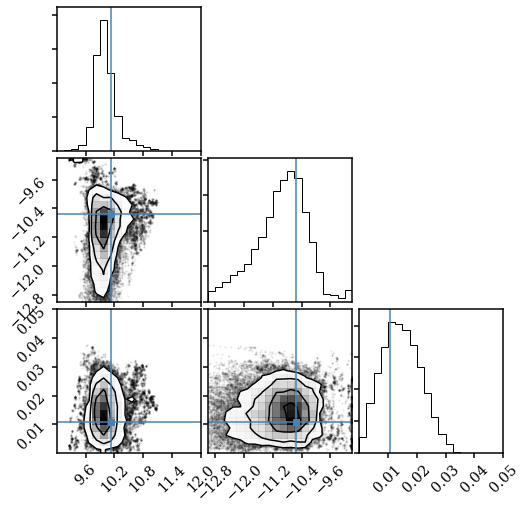

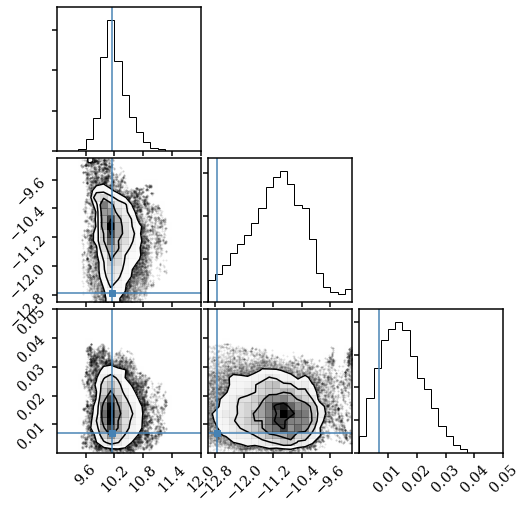

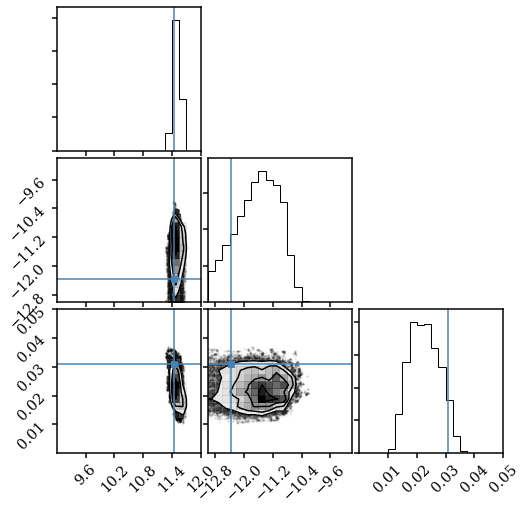

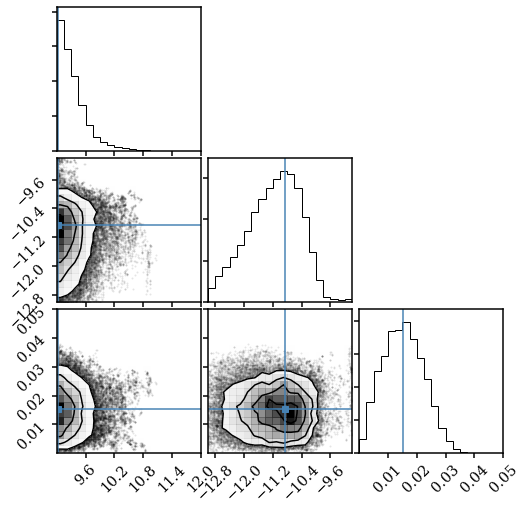

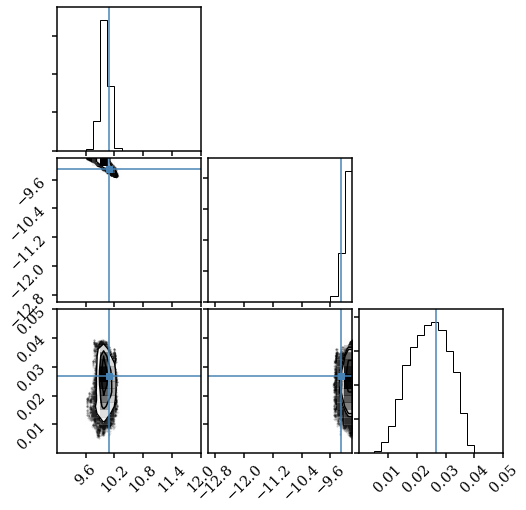

In [57]:
for i in range(5):#len(flat_chains)): 
    theta_deriv = np.array([flat_chains[i,:,0], np.log10(avgSFRs_1gyr_inf[i])-flat_chains[i,:,0], Z_MW_inf[i]])
    print(np.log10(avgSFRs_1gyr_true[i])-theta_obs[i][0])
    DFM.corner(theta_deriv.T, 
               truths=np.array([theta_obs[i][0], np.log10(avgSFRs_1gyr_true[i])-theta_obs[i][0], Z_MW_true[i]]), 
              range=[(9, 12), (-13, -9.), (0., 0.05)])

(-2.2, 0.4)

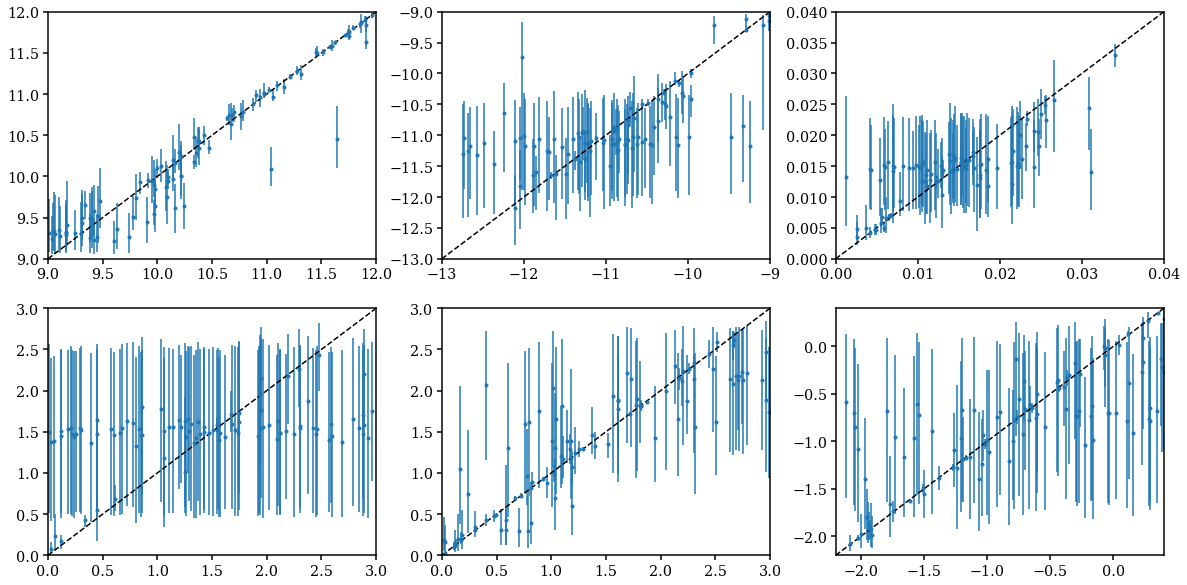

In [59]:
fig = plt.figure(figsize=(20,10))
sub = fig.add_subplot(231)
logm_quantiles = np.array([DFM.quantile(flat_chains[i,::10,0], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
sub.errorbar(theta_obs[:len(flat_chains),0], logm_quantiles[:,1], 
             yerr=[logm_quantiles[:,1]-logm_quantiles[:,0], logm_quantiles[:,2]-logm_quantiles[:,1]], fmt='.C0')
sub.plot([9., 12.], [9., 12], c='k', ls='--')
sub.set_xlim(9., 12.)
sub.set_ylim(9., 12.)

sub = fig.add_subplot(232)
logssfr_true = np.log10(avgSFRs_1gyr_true.flatten())-theta_obs[:len(flat_chains),0]
logssfr_quantiles = np.array([DFM.quantile(np.log10(avgSFRs_1gyr_inf[i,::10]) - flat_chains[i,::10,0], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
sub.errorbar(logssfr_true, logssfr_quantiles[:,1], 
             yerr=[logssfr_quantiles[:,1]-logssfr_quantiles[:,0], logssfr_quantiles[:,2]-logssfr_quantiles[:,1]], fmt='.C0')
sub.plot([-9., -15.], [-9., -15], c='k', ls='--')
sub.set_xlim(-13, -9.)
sub.set_ylim(-13, -9.)

sub = fig.add_subplot(233)
zmw_quantiles = np.array([DFM.quantile(Z_MW_inf[i][::10], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
sub.errorbar(Z_MW_true, zmw_quantiles[:,1], yerr=[zmw_quantiles[:,1] - zmw_quantiles[:,0], zmw_quantiles[:,2] - zmw_quantiles[:,1]], fmt='.C0')

sub.plot([0., 1e-1], [0., 1e-1], c='k', ls='--')
sub.set_xlim(0., 4e-2)
sub.set_ylim(0., 4e-2)

sub = fig.add_subplot(234)
dust1_quantiles = np.array([DFM.quantile(flat_chains[i,:,-3], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
sub.errorbar(theta_obs[:len(flat_chains),-3], dust1_quantiles[:,1], 
             yerr=[dust1_quantiles[:,1] - dust1_quantiles[:,0], dust1_quantiles[:,2] - dust1_quantiles[:,1]], fmt='.C0')
sub.plot([prior.range[0][-3], prior.range[1][-3]], [prior.range[0][-3], prior.range[1][-3]], c='k', ls='--')
sub.set_xlim(prior.range[0][-3], prior.range[1][-3])
sub.set_ylim(prior.range[0][-3], prior.range[1][-3])

sub = fig.add_subplot(235)
dust2_quantiles = np.array([DFM.quantile(flat_chains[i,:,-2], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
sub.errorbar(theta_obs[:len(flat_chains),-2], dust2_quantiles[:,1], 
             yerr=[dust2_quantiles[:,1] - dust2_quantiles[:,0], dust2_quantiles[:,2] - dust2_quantiles[:,1]], fmt='.C0')
sub.plot([prior.range[0][-2], prior.range[1][-2]], [prior.range[0][-2], prior.range[1][-2]], c='k', ls='--')
sub.set_xlim(prior.range[0][-2], prior.range[1][-2])
sub.set_ylim(prior.range[0][-2], prior.range[1][-2])

sub = fig.add_subplot(236)
dust_index_quantiles = np.array([DFM.quantile(flat_chains[i,:,-1], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])

sub.errorbar(theta_obs[:len(flat_chains),-1], dust_index_quantiles[:,1], 
             yerr=[dust_index_quantiles[:,1] - dust_index_quantiles[:,0], dust_index_quantiles[:,2] - dust_index_quantiles[:,1]], fmt='.C0')
sub.plot([prior.range[0][-1], prior.range[1][-1]], [prior.range[0][-1], prior.range[1][-1]], c='k', ls='--')
sub.set_xlim(prior.range[0][-1], prior.range[1][-1])
sub.set_ylim(prior.range[0][-1], prior.range[1][-1])

# `Corrprior.CorrectPrior` object to impose uniform prior on derived properties

In [17]:
CP_kde = Corrprior.CorrectPrior(
    m_nmf, 
    prior, 
    zred=z_obs,
    props=['logavgssfr_1gyr', 'z_mw'], 
    Nprior=100000, 
    method='kde', 
    debug=True
)

... calculating log avg sSFR_1Gyr
... calculating mass-weighted Z
... fitting prior(derived prop)
... fitting pdf using kde


In [55]:
ws_imp = [] 
for i, flat_chain in enumerate(flat_chains):
    w_imp = CP_kde.get_importance_weights(
        flat_chain[::10,:], 
        outlier=0.01,
        debug=True
    )
    ws_imp.append(w_imp)

... clipping values outside 2.94868e-02, 2.56195e+01
... clipping values outside 9.54046e-04, 2.56432e+01
... clipping values outside 2.32165e-02, 2.51001e+01
... clipping values outside 3.12801e-02, 2.56463e+01
... clipping values outside 1.61964e-01, 3.80512e+00
... clipping values outside 1.87420e-01, 2.56450e+01
... clipping values outside 4.84297e-03, 2.56452e+01
... clipping values outside 1.72346e-01, 4.79413e+00
... clipping values outside 1.14705e-02, 2.56458e+01
... clipping values outside 4.65051e-01, 2.56442e+01
... clipping values outside 3.96897e-03, 2.56448e+01
... clipping values outside 5.03758e-05, 2.56471e+01
... clipping values outside 1.23124e-02, 1.79274e+01
... clipping values outside 8.82084e-03, 2.56433e+01
... clipping values outside 9.16954e-03, 2.56467e+01
... clipping values outside 7.26810e-02, 2.56406e+01
... clipping values outside 6.41748e-03, 2.56400e+01
... clipping values outside 8.30805e-03, 2.56376e+01
... clipping values outside 3.41954e+00, 2.564

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


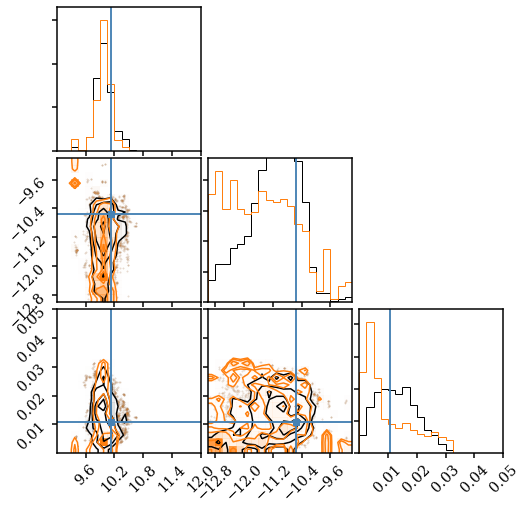

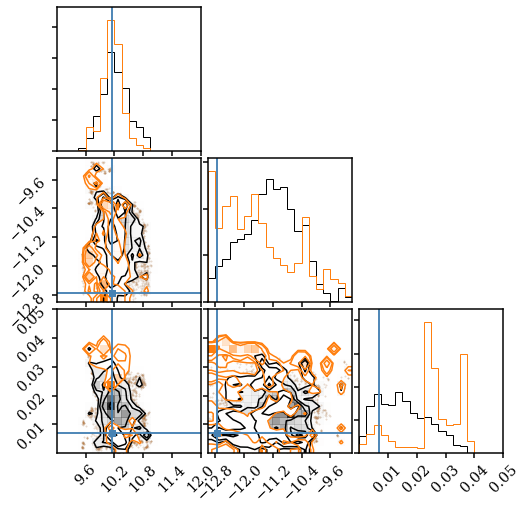

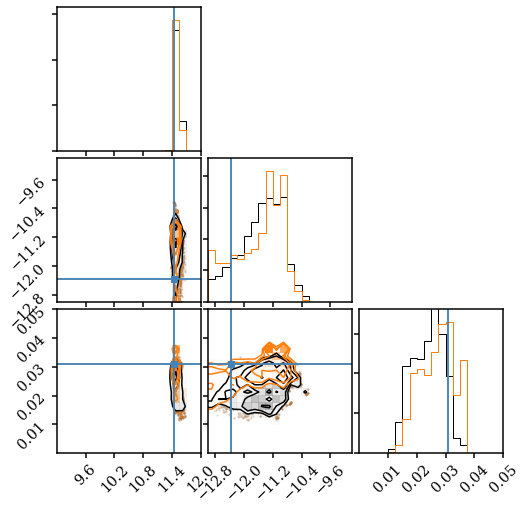

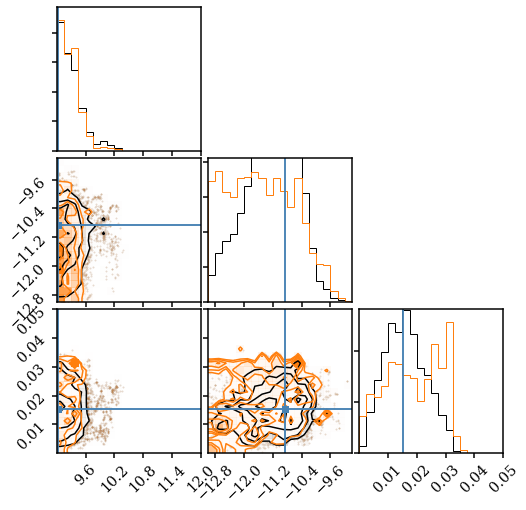

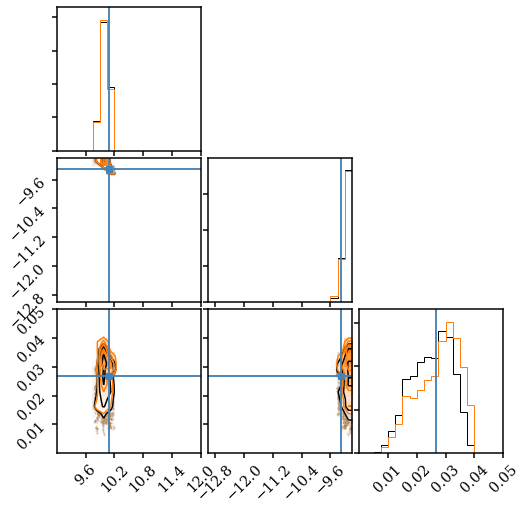

In [56]:
for i in range(5):#len(flat_chains)): 
    theta_deriv = np.array([flat_chains[i,:,0], np.log10(avgSFRs_1gyr_inf[i])-flat_chains[i,:,0], Z_MW_inf[i]])
    
    fig = DFM.corner(theta_deriv[:,::10].T, 
                     truths=np.array([theta_obs[i][0], np.log10(avgSFRs_1gyr_true[i])-theta_obs[i][0], Z_MW_true[i]]), 
                     range=[(9, 12), (-13., -9), (0., 0.05)], 
                     hist_kwargs={'density': True},
                     hist2d_kwargs={'smooth': True, 'plot_density': False, 'plot_datapoint': False})
    _ = DFM.corner(theta_deriv[:,::10].T, 
                   weights=ws_imp[i], 
                   truths=np.array([theta_obs[i][0], np.log10(avgSFRs_1gyr_true[i])-theta_obs[i][0], Z_MW_true[i]]),              
                   range=[(9, 12), (-13., -9), (0., 0.05)], color='C1',
                   hist_kwargs={'density': True},
                   hist2d_kwargs={'smooth': True, 'plot_density': False, 'plot_datapoint': False},
                   fig=fig)

(-2.2, 0.4)

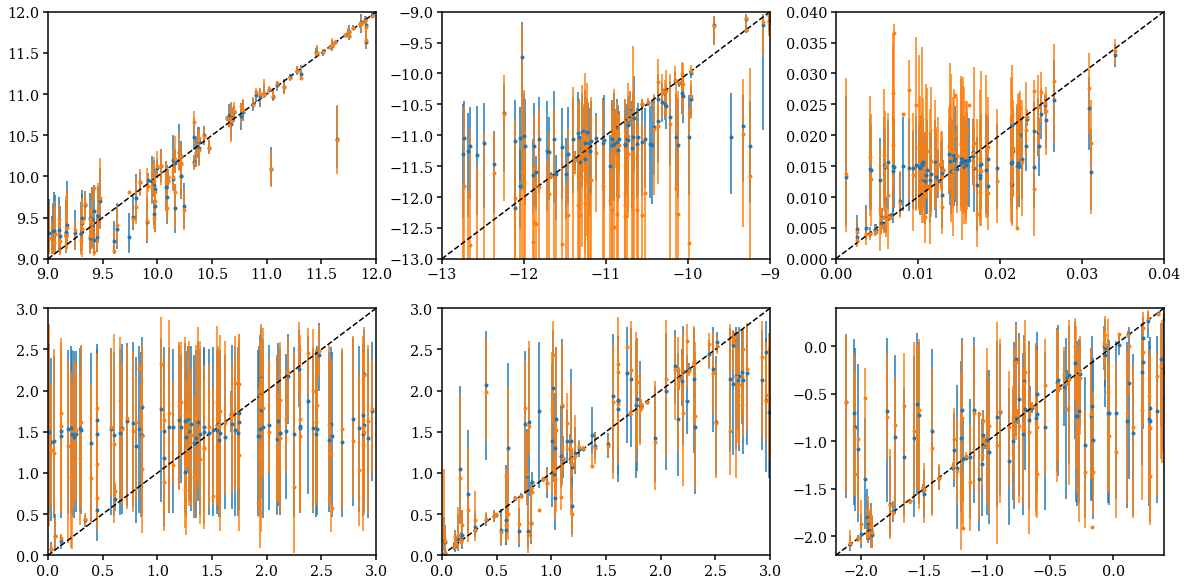

In [63]:
fig = plt.figure(figsize=(20,10))
sub = fig.add_subplot(231)
logm_quantiles = np.array([DFM.quantile(flat_chains[i,::10,0], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
sub.errorbar(theta_obs[:len(flat_chains),0], logm_quantiles[:,1], 
             yerr=[logm_quantiles[:,1]-logm_quantiles[:,0], logm_quantiles[:,2]-logm_quantiles[:,1]], fmt='.C0')

logm_quantiles = np.array([DFM.quantile(flat_chains[i,::10,0], [0.16, 0.5, 0.84], weights=ws_imp[i]) for i in range(flat_chains.shape[0])])
sub.errorbar(theta_obs[:len(flat_chains),0], logm_quantiles[:,1], 
             yerr=[logm_quantiles[:,1]-logm_quantiles[:,0], logm_quantiles[:,2]-logm_quantiles[:,1]], fmt='.C1')
sub.plot([9., 12.], [9., 12], c='k', ls='--')
sub.set_xlim(9., 12.)
sub.set_ylim(9., 12.)

sub = fig.add_subplot(232)
logssfr_true = np.log10(avgSFRs_1gyr_true.flatten())-theta_obs[:len(flat_chains),0]
logssfr_quantiles = np.array([DFM.quantile(np.log10(avgSFRs_1gyr_inf[i,::10]) - flat_chains[i,::10,0], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
sub.errorbar(logssfr_true, logssfr_quantiles[:,1], 
             yerr=[logssfr_quantiles[:,1]-logssfr_quantiles[:,0], logssfr_quantiles[:,2]-logssfr_quantiles[:,1]], fmt='.C0')

logssfr_quantiles = np.array([DFM.quantile(np.log10(avgSFRs_1gyr_inf[i,::10]) - flat_chains[i,::10,0], [0.16, 0.5, 0.84], weights=ws_imp[i]) for i in range(flat_chains.shape[0])])
sub.errorbar(logssfr_true, logssfr_quantiles[:,1], 
             yerr=[logssfr_quantiles[:,1]-logssfr_quantiles[:,0], logssfr_quantiles[:,2]-logssfr_quantiles[:,1]], fmt='.C1')

sub.plot([-9., -15.], [-9., -15], c='k', ls='--')
sub.set_xlim(-13, -9.)
sub.set_ylim(-13, -9.)

sub = fig.add_subplot(233)
zmw_quantiles = np.array([DFM.quantile(Z_MW_inf[i][::10], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
sub.errorbar(Z_MW_true, zmw_quantiles[:,1], yerr=[zmw_quantiles[:,1] - zmw_quantiles[:,0], zmw_quantiles[:,2] - zmw_quantiles[:,1]], fmt='.C0')

zmw_quantiles = np.array([DFM.quantile(Z_MW_inf[i][::10], [0.16, 0.5, 0.84], weights=ws_imp[i]) for i in range(flat_chains.shape[0])])
sub.errorbar(Z_MW_true, zmw_quantiles[:,1], yerr=[zmw_quantiles[:,1] - zmw_quantiles[:,0], zmw_quantiles[:,2] - zmw_quantiles[:,1]], fmt='.C1')
sub.plot([0., 1e-1], [0., 1e-1], c='k', ls='--')
sub.set_xlim(0., 4e-2)
sub.set_ylim(0., 4e-2)


sub = fig.add_subplot(234)
dust1_quantiles = np.array([DFM.quantile(flat_chains[i,:,-3], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
sub.errorbar(theta_obs[:len(flat_chains),-3], dust1_quantiles[:,1], 
             yerr=[dust1_quantiles[:,1] - dust1_quantiles[:,0], dust1_quantiles[:,2] - dust1_quantiles[:,1]], fmt='.C0')
dust1_quantiles = np.array([DFM.quantile(flat_chains[i,::10,-3], [0.16, 0.5, 0.84], weights=ws_imp[i]) for i in range(flat_chains.shape[0])])
sub.errorbar(theta_obs[:len(flat_chains),-3], dust1_quantiles[:,1], 
             yerr=[dust1_quantiles[:,1] - dust1_quantiles[:,0], dust1_quantiles[:,2] - dust1_quantiles[:,1]], fmt='.C1')
sub.plot([prior.range[0][-3], prior.range[1][-3]], [prior.range[0][-3], prior.range[1][-3]], c='k', ls='--')
sub.set_xlim(prior.range[0][-3], prior.range[1][-3])
sub.set_ylim(prior.range[0][-3], prior.range[1][-3])

sub = fig.add_subplot(235)
dust2_quantiles = np.array([DFM.quantile(flat_chains[i,:,-2], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
sub.errorbar(theta_obs[:len(flat_chains),-2], dust2_quantiles[:,1], 
             yerr=[dust2_quantiles[:,1] - dust2_quantiles[:,0], dust2_quantiles[:,2] - dust2_quantiles[:,1]], fmt='.C0')
dust2_quantiles = np.array([DFM.quantile(flat_chains[i,::10,-2], [0.16, 0.5, 0.84], weights=ws_imp[i]) for i in range(flat_chains.shape[0])])
sub.errorbar(theta_obs[:len(flat_chains),-2], dust2_quantiles[:,1], 
             yerr=[dust2_quantiles[:,1] - dust2_quantiles[:,0], dust2_quantiles[:,2] - dust2_quantiles[:,1]], fmt='.C1')
sub.plot([prior.range[0][-2], prior.range[1][-2]], [prior.range[0][-2], prior.range[1][-2]], c='k', ls='--')
sub.set_xlim(prior.range[0][-2], prior.range[1][-2])
sub.set_ylim(prior.range[0][-2], prior.range[1][-2])

sub = fig.add_subplot(236)
dust_index_quantiles = np.array([DFM.quantile(flat_chains[i,:,-1], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
sub.errorbar(theta_obs[:len(flat_chains),-1], dust_index_quantiles[:,1], 
             yerr=[dust_index_quantiles[:,1] - dust_index_quantiles[:,0], dust_index_quantiles[:,2] - dust_index_quantiles[:,1]], fmt='.C0')
dust_index_quantiles = np.array([DFM.quantile(flat_chains[i,::10,-1], [0.16, 0.5, 0.84], weights=ws_imp[i]) for i in range(flat_chains.shape[0])])
sub.errorbar(theta_obs[:len(flat_chains),-1], dust_index_quantiles[:,1], 
             yerr=[dust_index_quantiles[:,1] - dust_index_quantiles[:,0], dust_index_quantiles[:,2] - dust_index_quantiles[:,1]], fmt='.C1')
sub.plot([prior.range[0][-1], prior.range[1][-1]], [prior.range[0][-1], prior.range[1][-1]], c='k', ls='--')
sub.set_xlim(prior.range[0][-1], prior.range[1][-1])
sub.set_ylim(prior.range[0][-1], prior.range[1][-1])

(0.0, 0.04)

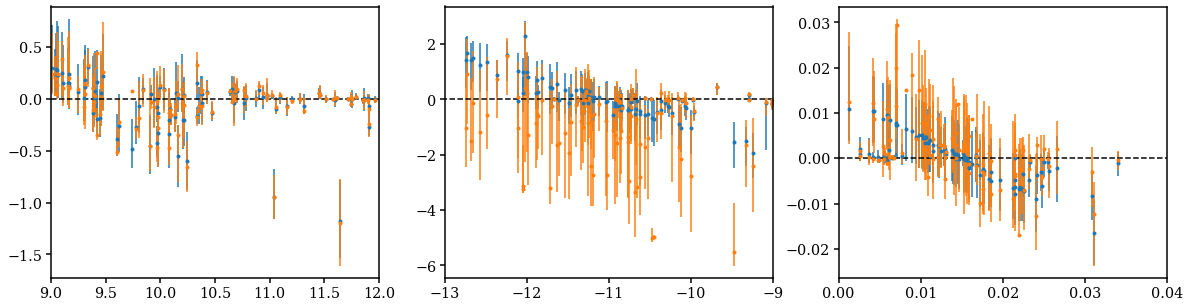

In [73]:
fig = plt.figure(figsize=(20,5))
sub = fig.add_subplot(131)
logm_quantiles = np.array([DFM.quantile(flat_chains[i,::10,0], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
sub.errorbar(theta_obs[:len(flat_chains),0], logm_quantiles[:,1] - theta_obs[:len(flat_chains),0], 
             yerr=[logm_quantiles[:,1]-logm_quantiles[:,0], logm_quantiles[:,2]-logm_quantiles[:,1]], fmt='.C0')

logm_quantiles = np.array([DFM.quantile(flat_chains[i,::10,0], [0.16, 0.5, 0.84], weights=ws_imp[i]) for i in range(flat_chains.shape[0])])
sub.errorbar(theta_obs[:len(flat_chains),0], logm_quantiles[:,1] - theta_obs[:len(flat_chains),0], 
             yerr=[logm_quantiles[:,1]-logm_quantiles[:,0], logm_quantiles[:,2]-logm_quantiles[:,1]], fmt='.C1')
sub.plot([9., 12.], [0, 0], c='k', ls='--')
sub.set_xlim(9., 12.)
#sub.set_ylim(9., 12.)

sub = fig.add_subplot(132)
logssfr_true = np.log10(avgSFRs_1gyr_true.flatten())-theta_obs[:len(flat_chains),0]
logssfr_quantiles = np.array([DFM.quantile(np.log10(avgSFRs_1gyr_inf[i,::10]) - flat_chains[i,::10,0], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
sub.errorbar(logssfr_true, logssfr_quantiles[:,1] - logssfr_true, 
             yerr=[logssfr_quantiles[:,1]-logssfr_quantiles[:,0], logssfr_quantiles[:,2]-logssfr_quantiles[:,1]], fmt='.C0')

logssfr_quantiles = np.array([DFM.quantile(np.log10(avgSFRs_1gyr_inf[i,::10]) - flat_chains[i,::10,0], [0.16, 0.5, 0.84], weights=ws_imp[i]) for i in range(flat_chains.shape[0])])
sub.errorbar(logssfr_true, logssfr_quantiles[:,1] - logssfr_true, 
             yerr=[logssfr_quantiles[:,1]-logssfr_quantiles[:,0], logssfr_quantiles[:,2]-logssfr_quantiles[:,1]], fmt='.C1')

sub.plot([-9., -15.], [0, 0], c='k', ls='--')
sub.set_xlim(-13, -9.)
#sub.set_ylim(-13, -9.)

sub = fig.add_subplot(133)
zmw_quantiles = np.array([DFM.quantile(Z_MW_inf[i], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
sub.errorbar(Z_MW_true, zmw_quantiles[:,1].flatten() - Z_MW_true.flatten(), 
             yerr=[zmw_quantiles[:,1] - zmw_quantiles[:,0], zmw_quantiles[:,2] - zmw_quantiles[:,1]], fmt='.C0')

zmw_quantiles = np.array([DFM.quantile(Z_MW_inf[i][::10], [0.16, 0.5, 0.84], weights=ws_imp[i]) for i in range(flat_chains.shape[0])])
sub.errorbar(Z_MW_true, zmw_quantiles[:,1].flatten() - Z_MW_true.flatten(), 
             yerr=[zmw_quantiles[:,1] - zmw_quantiles[:,0], zmw_quantiles[:,2] - zmw_quantiles[:,1]], fmt='.C1')
sub.plot([0., 1e-1], [0., 0.], c='k', ls='--')
sub.set_xlim(0., 4e-2)
#sub.set_ylim(0., 4e-2)